# Projet ML — Classification de Compositeurs à partir de fichier MIDI

Dans ce projet, on implémente un pipeline complet de Machine Learning supervisé permettant de prédire automatiquement le compositeur d’une œuvre de piano à partir d’un fichier MIDI.  


### Configuration de music21 avec MuseScore

   `music21` nécessite MuseScore pour certaines opérations comme la détection de tonalité.  
    Nous configurons ici le chemin vers MuseScore 3.


In [3]:
import music21

music21.environment.set('musicxmlPath', r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe")
music21.environment.set('musescoreDirectPNGPath', r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)


### Chargement du dataset MAESTRO


In [5]:
BASE_DIR = "dataset_piano/maestro-v3.0.0"
META_CSV = os.path.join(BASE_DIR, "maestro-v3.0.0.csv")

meta = pd.read_csv(META_CSV)

meta.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


### Années d'enregistrement disponibles dans le dataset

In [6]:
meta.columns
years = sorted(meta["year"].unique())
print("Dossiers disponibles dans MAESTRO :", years)

Dossiers disponibles dans MAESTRO : [np.int64(2004), np.int64(2006), np.int64(2008), np.int64(2009), np.int64(2011), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2017), np.int64(2018)]



### Sélection des dossiers souhaités pour l'entraînement


In [7]:
YEARS = [2008, 2006, 2004, 2009, 2011, 2013, 2014, 2015, 2017, 2018] # On choisi le ou les dossier(s) qu'on veut ici

subset = meta[meta["year"].isin(YEARS)].copy()

print(f"Nombre total de MIDI sélectionnés : {subset.shape[0]}")
subset.head()


Nombre total de MIDI sélectionnés : 1276


,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


### Génération des chemins complets vers les fichiers MIDI

In [8]:
subset["midi_path"] = subset["midi_filename"].apply(
    lambda p: os.path.join(BASE_DIR, p)
)

print("🔗 Exemple de chemins MIDI générés :")
subset["midi_path"].head()


🔗 Exemple de chemins MIDI générés :


0    dataset_piano/maestro-v3.0.0\2018/MIDI-Unproce...
1    dataset_piano/maestro-v3.0.0\2008/MIDI-Unproce...
2    dataset_piano/maestro-v3.0.0\2017/MIDI-Unproce...
3    dataset_piano/maestro-v3.0.0\2004/MIDI-Unproce...
4    dataset_piano/maestro-v3.0.0\2006/MIDI-Unproce...
Name: midi_path, dtype: object

### Liste des compositeurs


In [9]:
composer_counts = subset["canonical_composer"].value_counts()
print("Nombre de compositions par compositeur :")
print(composer_counts)


Nombre de compositions par compositeur :
canonical_composer
Frédéric Chopin                                       201
Franz Schubert                                        186
Ludwig van Beethoven                                  146
Johann Sebastian Bach                                 145
Franz Liszt                                           131
Sergei Rachmaninoff                                    59
Robert Schumann                                        49
Claude Debussy                                         45
Joseph Haydn                                           40
Wolfgang Amadeus Mozart                                38
Alexander Scriabin                                     35
Domenico Scarlatti                                     31
Felix Mendelssohn                                      28
Johannes Brahms                                        26
Franz Schubert / Franz Liszt                           10
Isaac Albéniz                                           7
Modest Musso

### Extraction des features musicales


In [10]:
from music21 import converter, note, chord, key
from tqdm import tqdm

### Fonction d’extraction des features MIDI


In [11]:
def extract_features_from_midi(path):
    try:
        midi = converter.parse(path)
    except Exception as e:
        print(f"Erreur lors du chargement de {path} : {e}")
        return None

    notes = []
    durations = []

    # Extraction des notes
    for element in midi.flat.notes:
        if isinstance(element, note.Note):
            notes.append(element.pitch.midi)
            durations.append(element.duration.quarterLength)

        elif isinstance(element, chord.Chord):
            # On prend la moyenne des notes de l'accord
            notes.append(int(np.mean([p.midi for p in element.pitches])))
            durations.append(element.duration.quarterLength)

    # Minimum : 2 notes pour calculer intervalles
    if len(notes) < 2:
        return None

    intervals = np.diff(notes)

    # Densité (notes / durée totale)
    try:
        total_seconds = midi.duration.seconds
    except:
        total_seconds = None

    if total_seconds and total_seconds > 0:
        note_density = len(notes) / total_seconds
    else:
        note_density = len(notes)

    try:
        k = midi.analyze('key')
        key_tonality = str(k.tonic) + " " + k.mode
    except:
        key_tonality = "Inconnu"

    return {
        "pitch_mean": np.mean(notes),
        "pitch_std": np.std(notes),
        "pitch_min": np.min(notes),
        "pitch_max": np.max(notes),
        "interval_mean": np.mean(intervals),
        "interval_std": np.std(intervals),
        "note_density": note_density,
        "duration_mean": np.mean(durations),
        "key": key_tonality
    }


### Extraction de tout le dataset


In [12]:
feature_rows = []

print("Extraction des features...")

for idx, row in tqdm(subset.iterrows(), total=len(subset)):
    features = extract_features_from_midi(row["midi_path"])

    if features is None:
        continue

    features["composer"] = row["canonical_composer"]
    features["path"] = row["midi_path"]
    
    feature_rows.append(features)

print(f" Extraction terminée : {len(feature_rows)} fichiers traités.")


Extraction des features...


  0%|          | 0/1276 [00:00<?, ?it/s]c:\Users\jerem\Documents\Alyra\Formation développement IA\Projet\.venv\lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
100%|██████████| 1276/1276 [1:57:25<00:00,  5.52s/it]  

 Extraction terminée : 1276 fichiers traités.


### DataFrame final des features

In [13]:
df_features = pd.DataFrame(feature_rows)
print("Aperçu des features extraites :")
df_features.head()


Aperçu des features extraites :


,pitch_mean,pitch_std,pitch_min,pitch_max,interval_mean,interval_std,note_density,duration_mean,key,composer,path
0,63.445711,12.320666,28,100,-0.010133,14.188294,3159,0.861955,B minor,Alban Berg,dataset_piano/maestro-v3.0.0\2018/MIDI-Unproce...
1,63.469688,12.592714,28,98,-0.005775,14.802442,3464,0.982871,E minor,Alban Berg,dataset_piano/maestro-v3.0.0\2008/MIDI-Unproce...
2,63.456482,12.689923,28,98,-0.011791,14.924598,2206,0.751549,E minor,Alban Berg,dataset_piano/maestro-v3.0.0\2017/MIDI-Unproce...
3,60.739141,10.857554,24,96,-0.000508,13.489608,3937,0.727479,B- minor,Alexander Scriabin,dataset_piano/maestro-v3.0.0\2004/MIDI-Unproce...
4,66.474168,12.120907,26,100,0.018955,14.186344,1742,0.494738,D minor,Alexander Scriabin,dataset_piano/maestro-v3.0.0\2006/MIDI-Unproce...


### 🔍 Détection des valeurs manquantes

In [14]:
print("Vérification des valeurs manquantes :")
print(df_features.isnull().sum())

missing_val = df_features[df_features.isnull().any(axis=1)]
print(f"Nombre de lignes ayant des valeurs manquantes : {len(missing_val)}")
print("Lignes contenant des valeurs manquantes :")
display(missing_val.head())



Vérification des valeurs manquantes :
pitch_mean       0
pitch_std        0
pitch_min        0
pitch_max        0
interval_mean    0
interval_std     0
note_density     0
duration_mean    0
key              0
composer         0
path             0
dtype: int64
Nombre de lignes ayant des valeurs manquantes : 0
Lignes contenant des valeurs manquantes :


,pitch_mean,pitch_std,pitch_min,pitch_max,interval_mean,interval_std,note_density,duration_mean,key,composer,path


### Vérification du dataframe extrait

In [15]:
print("Colonnes :", df_features.columns.tolist())
print("Taille du dataset :", df_features.shape)

print("Enregistrements par compositeurs :")
print(df_features["composer"].value_counts())


Colonnes : ['pitch_mean', 'pitch_std', 'pitch_min', 'pitch_max', 'interval_mean', 'interval_std', 'note_density', 'duration_mean', 'key', 'composer', 'path']
Taille du dataset : (1276, 11)
Enregistrements par compositeurs :
composer
Frédéric Chopin                                       201
Franz Schubert                                        186
Ludwig van Beethoven                                  146
Johann Sebastian Bach                                 145
Franz Liszt                                           131
Sergei Rachmaninoff                                    59
Robert Schumann                                        49
Claude Debussy                                         45
Joseph Haydn                                           40
Wolfgang Amadeus Mozart                                38
Alexander Scriabin                                     35
Domenico Scarlatti                                     31
Felix Mendelssohn                                      28
Johannes Brah

### Filtrage des compositeurs ayant peu de d'enregistrements


In [16]:
df_filtered = df_features.groupby('composer').filter(lambda x: len(x) >= 20
)

print("Taille après filtrage :", df_filtered.shape)
print("\nCompositions par compositeur après filtrage :")
print(df_filtered["composer"].value_counts())


Taille après filtrage : (1160, 11)

Compositions par compositeur après filtrage :
composer
Frédéric Chopin            201
Franz Schubert             186
Ludwig van Beethoven       146
Johann Sebastian Bach      145
Franz Liszt                131
Sergei Rachmaninoff         59
Robert Schumann             49
Claude Debussy              45
Joseph Haydn                40
Wolfgang Amadeus Mozart     38
Alexander Scriabin          35
Domenico Scarlatti          31
Felix Mendelssohn           28
Johannes Brahms             26
Name: count, dtype: int64


### Séparation des variables x et y

In [17]:
X = df_filtered.drop(columns=["composer", "path", "key"])  # On garde que les features numériques
y = df_filtered["composer"]

print("Shape X :", X.shape)
print("Shape y :", y.shape)


Shape X : (1160, 8)
Shape y : (1160,)


In [18]:
# Exemple de ligne du dataframe pour l'entraînnement

print("x :")
print(X.iloc[0])
print("y :", y.iloc[0])


x :
pitch_mean         60.739141
pitch_std          10.857554
pitch_min          24.000000
pitch_max          96.000000
interval_mean      -0.000508
interval_std       13.489608
note_density     3937.000000
duration_mean       0.727479
Name: 3, dtype: float64
y : Alexander Scriabin


## Train/Test Split


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Taille train :", X_train.shape)
print("Taille test  :", X_test.shape)


Taille train : (928, 8)
Taille test  : (232, 8)


### On va garder un historique des différents entraînement pour les comparer

In [61]:
history = []

In [62]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(name, pipeline, X_train, X_test, y_train, y_test, history):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro") # Tester sur weighted et micro => déséquilibré entre les compositeurs
    
    history.append({
        "name": name,
        "accuracy": acc,
        "f1_macro": f1
    })
    
    print(f"Résultats pour le modèle : {name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Macro : {f1:.4f}")
    
    return pipeline


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### 1 - Algorithme de classification : Régression logistique

In [66]:

# pipeline_logistic_v1

from sklearn.linear_model import LogisticRegression

pipeline_logistic_v1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    ))
])

pipeline_logistic_v1 = evaluate_model(
    "Logistic Regression v1",
    pipeline_logistic_v1,
    X_train, X_test,
    y_train, y_test,
    history
)

Résultats pour le modèle : Logistic Regression v1
Accuracy : 0.5776
F1 Macro : 0.5085


c:\Users\jerem\Documents\Alyra\Formation développement IA\Projet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [67]:

# pipeline_logistic_v2

pipeline_logistic_v2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty='l1',           # Régularisation L1 (feature selection)
        C=0.1,                  # Régularisation forte
        solver='saga',          # Seul solver compatible L1 + multinomial
        max_iter=2000,
        multi_class='multinomial',
        random_state=42
    ))
])

pipeline_logistic_v2 = evaluate_model(
    "Logistic Regression v2 (L1, C=0.1)",
    pipeline_logistic_v2,
    X_train, X_test,
    y_train, y_test,
    history
)

Résultats pour le modèle : Logistic Regression v2 (L1, C=0.1)
Accuracy : 0.4871
F1 Macro : 0.2939


c:\Users\jerem\Documents\Alyra\Formation développement IA\Projet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [68]:

# pipeline_logistic_v3

pipeline_logistic_v3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty='l2',           # Régularisation L2 (standard)
        C=1.0,                  # Régularisation modérée
        solver='lbfgs',
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced',  # ← Gère déséquilibre classes
        random_state=42
    ))
])

pipeline_logistic_v3 = evaluate_model(
    "Logistic Regression v3 (balanced)",
    pipeline_logistic_v3,
    X_train, X_test,
    y_train, y_test,
    history
)

Résultats pour le modèle : Logistic Regression v3 (balanced)
Accuracy : 0.5388
F1 Macro : 0.5064


c:\Users\jerem\Documents\Alyra\Formation développement IA\Projet\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### 2 - Algorithme de classification : Random Forest

In [69]:
# pipeline_randomForest_v1

pipeline_randomForest_v1 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

pipeline_randomForest_v1 = evaluate_model(
    "Random Forest v1",
    pipeline_randomForest_v1,
    X_train, X_test,
    y_train, y_test,
    history
)


Résultats pour le modèle : Random Forest v1
Accuracy : 0.8060
F1 Macro : 0.7521


In [70]:

# pipeline_randomForest_v2

pipeline_randomForest_v2 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=800,
        max_depth=20,
        min_samples_split=3,
        min_samples_leaf=1,
        random_state=42
    ))
])

pipeline_randomForest_v2 = evaluate_model(
    "Random Forest v2",
    pipeline_randomForest_v2,
    X_train, X_test,
    y_train, y_test,
    history
)


Résultats pour le modèle : Random Forest v2
Accuracy : 0.8060
F1 Macro : 0.7471


In [71]:
# pipeline_randomForest_v3

pipeline_randomForest_v3 = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=1200,
        max_depth=25,
        max_features="sqrt",
        min_samples_split=4,
        min_samples_leaf=2,
        bootstrap=True,
        random_state=42
    ))
])

pipeline_randomForest_v3 = evaluate_model(
    "Random Forest v3",
    pipeline_randomForest_v3,
    X_train, X_test,
    y_train, y_test,
    history
)


Résultats pour le modèle : Random Forest v3
Accuracy : 0.8017
F1 Macro : 0.7338


In [72]:
import pandas as pd

df_hist = pd.DataFrame(history)
print(df_hist)


                                 name  accuracy  f1_macro
0                 Logistic Regression  0.577586  0.508515
1                 Logistic Regression  0.577586  0.508515
2              Logistic Regression v1  0.577586  0.508515
3  Logistic Regression v2 (L1, C=0.1)  0.487069  0.293878
4   Logistic Regression v3 (balanced)  0.538793  0.506385
5                    Random Forest v1  0.806034  0.752091
6                    Random Forest v2  0.806034  0.747084
7                    Random Forest v3  0.801724  0.733757


### Évaluation du modèle sur le jeu de test


In [73]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = pipeline_randomForest_v1.predict(X_test)

print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test, y_pred))


Accuracy :  0.8060344827586207
Classification Report :
                         precision    recall  f1-score   support

     Alexander Scriabin       0.67      0.57      0.62         7
         Claude Debussy       1.00      0.44      0.62         9
     Domenico Scarlatti       0.60      0.50      0.55         6
      Felix Mendelssohn       1.00      0.83      0.91         6
            Franz Liszt       0.78      0.81      0.79        26
         Franz Schubert       0.75      0.81      0.78        37
        Frédéric Chopin       0.73      0.93      0.81        40
  Johann Sebastian Bach       0.90      0.97      0.93        29
        Johannes Brahms       1.00      0.20      0.33         5
           Joseph Haydn       0.88      0.88      0.88         8
   Ludwig van Beethoven       0.86      0.83      0.84        29
        Robert Schumann       0.80      0.80      0.80        10
    Sergei Rachmaninoff       0.90      0.75      0.82        12
Wolfgang Amadeus Mozart       1.00

## Matrice de confusion


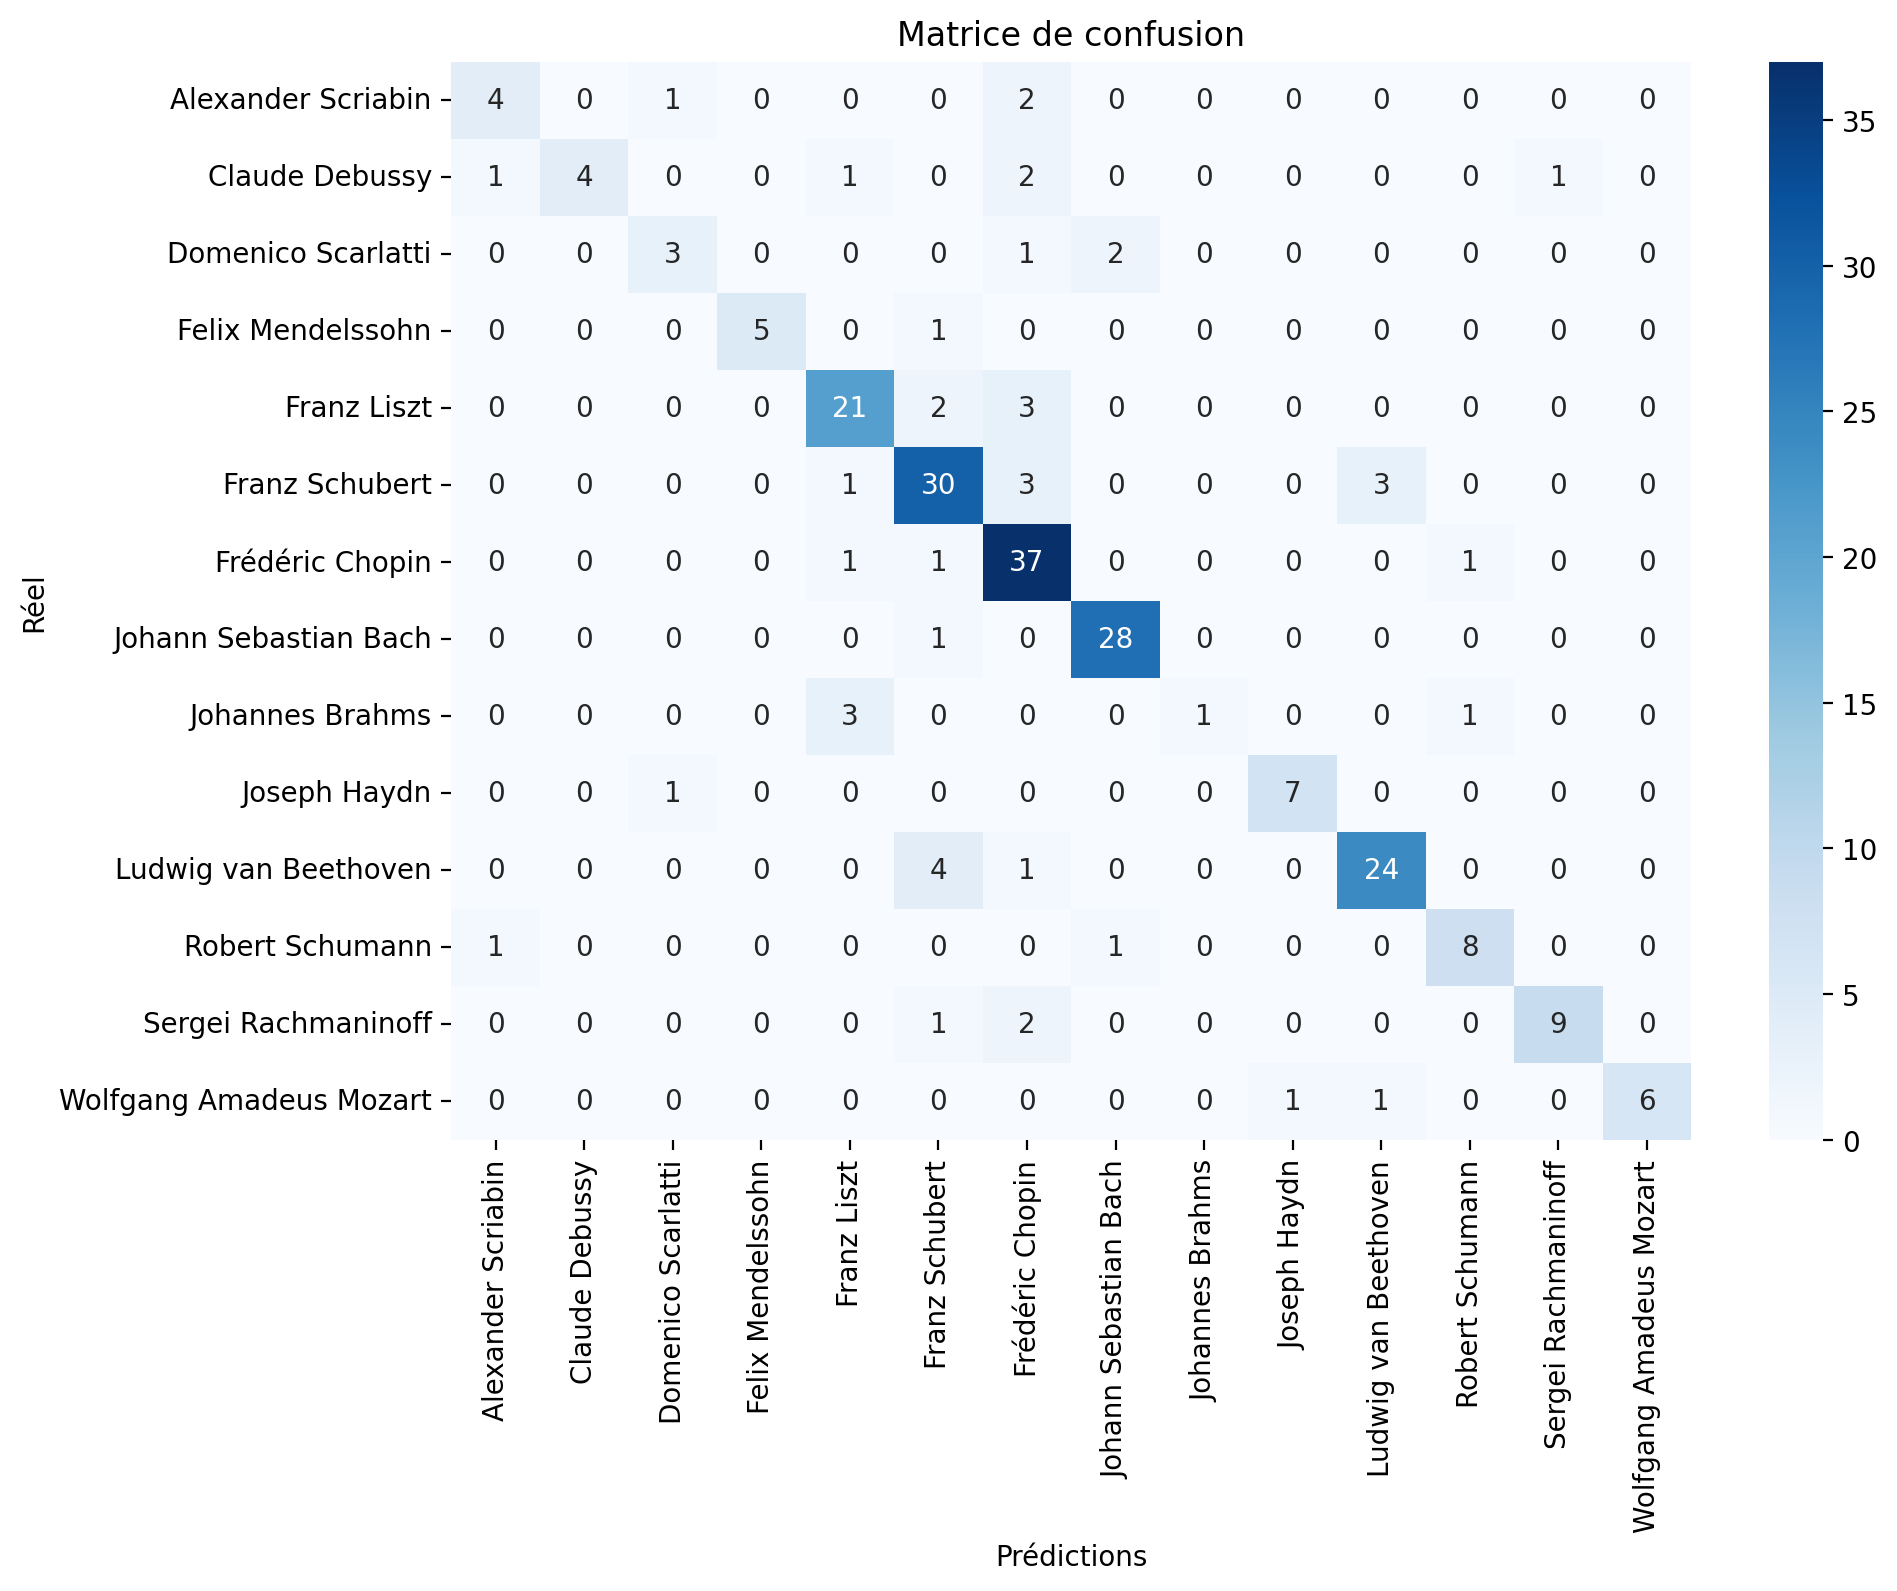

In [74]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=pipeline_randomForest_v1.classes_,
            yticklabels=pipeline_randomForest_v1.classes_)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()


### Importance des features 


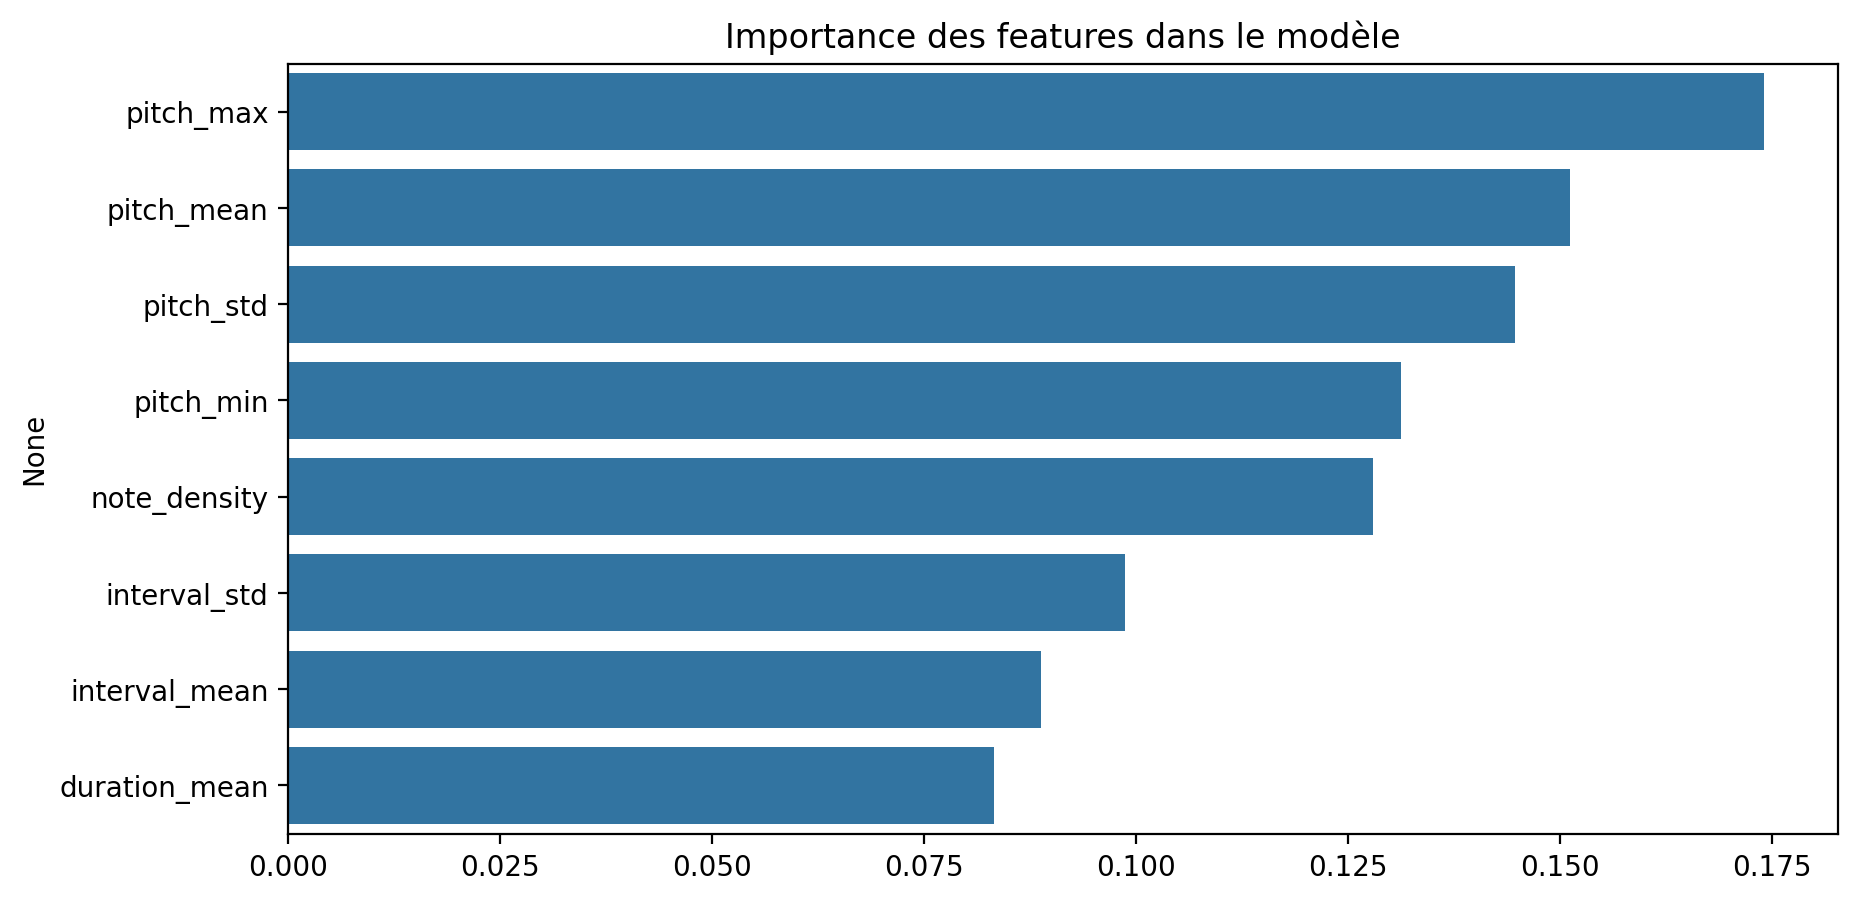


 Importance détaillée :

pitch_max       : 0.174
pitch_mean      : 0.151
pitch_std       : 0.145
pitch_min       : 0.131
note_density    : 0.128
interval_std    : 0.099
interval_mean   : 0.089
duration_mean   : 0.083


In [75]:
importances = pipeline_randomForest_v1.named_steps["model"].feature_importances_
features = X.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Importance des features dans le modèle")
plt.show()

print("\n Importance détaillée :\n")
for i in indices:
    print(f"{features[i]:15s} : {importances[i]:.3f}")


## Démonstration de prédiction d'un compositeur


In [53]:
def predict_one_file(path, pipeline):

    features = extract_features_from_midi(path)
    if features is None:
        print("Impossible d'extraire les features.")
        return None
    
    df_input = pd.DataFrame([features])
    
    for col in ["key", "path"]: # Colonnes non numériques
        if col in df_input.columns:
            df_input = df_input.drop(columns=[col])
    
    df_input = df_input[X.columns]

    # Prédiction à partir du modèle (V1 ici)
    pred = pipeline.predict(df_input)[0]
    proba = pipeline.predict_proba(df_input)[0]
    
    print("Compositeur prédit :", pred)
    print("Probabilités (top 5) :")

    top5_idx = np.argsort(proba)[::-1][:5]
    for idx in top5_idx:
        print(f"{pipeline.classes_[idx]:15s} -> {proba[idx]:.3f}")
    
    return pred


In [80]:
predict_one_file("dataset_piano/maestro-v3.0.0/2008/MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--3.midi", pipeline_randomForest_v3)


Compositeur prédit : Frédéric Chopin
Probabilités (top 5) :
Frédéric Chopin -> 0.735
Claude Debussy  -> 0.078
Sergei Rachmaninoff -> 0.072
Ludwig van Beethoven -> 0.021
Alexander Scriabin -> 0.018


c:\Users\jerem\Documents\Alyra\Formation développement IA\Projet\.venv\lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


'Frédéric Chopin'